Compute displacement and stresses in the domain from a screw dislocation on a complex curve.

# 1 - Preliminaries: interpolation, hypersingular integrals.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

from common import gauss_rule, double_layer_matrix, qbx_choose_centers, qbx_expand_matrix, qbx_interior_eval

First off, it's going to be helpful to be able to interpolate functions. This snippet of code below is an implementation of [barycentric Lagrange interpolation](https://people.maths.ox.ac.uk/trefethen/barycentric.pdf). I strongly recommend that paper if you've never run into barycentric Lagrange interpolation before!

In [2]:
def interp_weights(x):
    dist = x[:, None] - x[None, :]
    np.fill_diagonal(dist, 1.0)
    weights = 1.0 / np.prod(dist, axis=1)
    return weights

def barycentric_eval(eval_pts, interp_pts, interp_wts, fnc_vals):
    dist = eval_pts[:, None] - interp_pts[None, :]
    kernel = interp_wts[None, :] / dist
    return (kernel.dot(fnc_vals)) / np.sum(kernel, axis=1)

This is a little check to make sure our interpolation snippet is working correctly. We interpolate $sin(5x)$ (plotted with a solid black line) on a grid of 7 points (blue dots) and plot the resulting approximate function (red dashes line). This isn't a rigorous check, but it seems like it's working! Convergence is very fast if we increase the interpolation order.

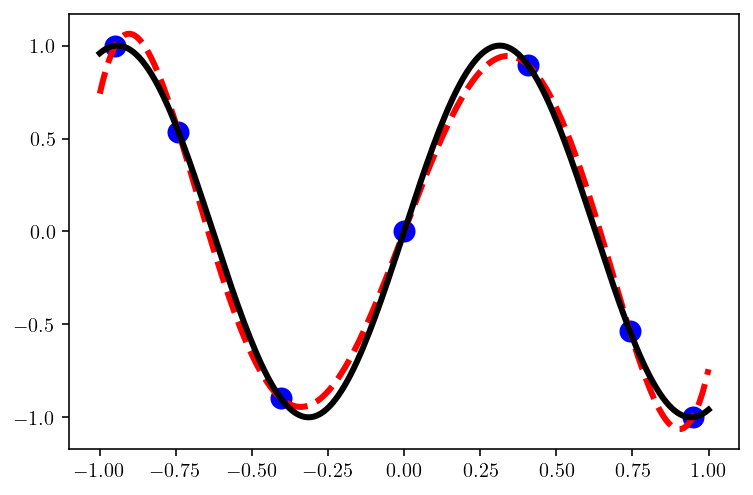

In [3]:
qx, qw = gauss_rule(7)
gauss_interp_wts = interp_weights(qx)
xs = np.linspace(-1, 1, 200)
fqx = np.sin(5 * qx)
v = barycentric_eval(xs, qx, gauss_interp_wts, fqx)
plt.plot(qx, fqx, 'bo', markersize=10)
plt.plot(xs, v, 'r--')
plt.plot(xs, np.sin(5 * xs), 'k-')
plt.show()

In [ ]:
def interp_fnc(f, in_xhat, out_xhat):
    iw = interp_weights(in_xhat)
    return barycentric_eval(out_xhat, in_xhat, iw, f)

def interp_surface(in_surf, in_xhat, out_xhat):
    out = []
    for f in in_surf[:4]:
        out.append(interp_fnc(f, in_xhat, out_xhat))
    out.append(in_surf[4])
    return out

The second preliminary is to build an integrator for a second kernel function! We're going to compute the directional derivative of the potential via a kernel sometimes called the "hypersingular" kernel. In earthquake speak, still operating in the antiplane setting, since we set the observation point normal to $(0, 1)$, we're computing the stress component $\sigma_{yz}$. If we set the observation normal to $(1, 0)$, we would compute $\sigma_{xz}$.

In [4]:
def hypersingular_matrix(surface, quad_rule, obsx, obsy):
    srcx, srcy, srcnx, srcny, curve_jacobian = surface

    dx = obsx[:, None] - srcx[None, :]
    dy = obsy[:, None] - srcy[None, :]
    r2 = dx ** 2 + dy ** 2
    
    obsnx = 0.0 * obsx
    obsny = np.full_like(obsx, 1.0)
    
    srcn_dot_obsn = srcnx[None, :] * obsnx[:, None] + srcny[None, :] * obsny[:, None]
    d_dot_srcn = dx * srcnx[None, :] + dy * srcny[None, :]
    d_dot_obsn = dx * obsnx[:, None] + dy * obsny[:, None]
    
    # The definition of the hypersingular kernel.
    integrand = (srcn_dot_obsn - (2 * d_dot_srcn * d_dot_obsn / r2)) / (2 * np.pi * r2)

    return integrand * curve_jacobian * quad_rule[1][None, :]

In [7]:
def qbx_example(kernel, surface_fnc, n, offset_mult, kappa, qbx_p):
    
    
    def slip_fnc(xhat):
        # This must be zero at the endpoints!
        return np.cos(xhat * np.pi) + 1.0
    
    quad_rule_low = gauss_rule(n)
    surface_low = surface_fnc(quad_rule_low[0])
    slip_low = slip_fnc(surface_low[0])
    
    nobs = 400
    zoomx = [-1.5, 1.5]
    zoomy = [-1.5, 1.5]
    xs = np.linspace(*zoomx, nobs)
    ys = np.linspace(*zoomy, nobs)
    obsx, obsy = np.meshgrid(xs, ys)

    disp_low = kernel(
        surface   = surface_low,
        obsx      = obsx.flatten(), 
        obsy      = obsy.flatten(),
        quad_rule = quad_rule_low
    ).dot(slip_low).reshape(obsx.shape)

    n = 2000
    quad_rule_high = gauss_rule(n)
    surface_high = interp_surface(surface_low, quad_rule_low[0], quad_rule_high[0])
    slip_high = interp_fnc(slip_low, quad_rule_low[0], quad_rule_high[0])
    disp_high = kernel(
        surface   = surface_high,
        obsx      = obsx.flatten(), 
        obsy      = obsy.flatten(),
        quad_rule = quad_rule_high
    ).dot(slip_high).reshape(obsx.shape)

    n = surface_low[0].shape[0] * kappa
    quad_rule_qbx = gauss_rule(n)
    surface_qbx = interp_surface(surface_low, quad_rule_low[0], quad_rule_qbx[0])
    slip_qbx = interp_fnc(slip_low, quad_rule_low[0], quad_rule_qbx[0])

    qbx_center_x1, qbx_center_y1, qbx_r1 = qbx_choose_centers(surface_low, quad_rule_low, mult = offset_mult, direction = 1.0)
    qbx_center_x2, qbx_center_y2, qbx_r2 = qbx_choose_centers(surface_low, quad_rule_low, mult = offset_mult, direction = -1.0)
    qbx_center_x = np.concatenate([qbx_center_x1, qbx_center_x2])
    qbx_center_y = np.concatenate([qbx_center_y1, qbx_center_y2])
    qbx_r = np.concatenate([qbx_r1, qbx_r2])

    plt.plot(surface_qbx[0], surface_qbx[1], 'k-')
    plt.plot(qbx_center_x, qbx_center_y, 'r.')
    plt.show()

    Qexpand = qbx_expand_matrix(kernel, surface_qbx, quad_rule_qbx, qbx_center_x, qbx_center_y, qbx_r, qbx_p = qbx_p)
    qbx_coeffs = Qexpand.dot(slip_qbx)
    disp_qbx = qbx_interior_eval(kernel, surface_low, quad_rule_low, slip_low, obsx, obsy, qbx_center_x, qbx_center_y, qbx_r, qbx_coeffs)

    plt.figure(figsize=(16,12))
    plt.subplot(2, 3, 1)
    plt.title('Naive solution')
    levels = np.linspace(-1.0,1.0,11)
    cntf = plt.contourf(obsx, obsy, disp_low, levels = levels, extend="both")
    plt.contour(obsx, obsy, disp_low, colors='k', linestyles='-', linewidths=0.5, levels = levels, extend="both")
    plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

    plt.subplot(2, 3, 2)
    plt.title('"Accurate" solution')
    cntf = plt.contourf(obsx, obsy, disp_high, levels = levels, extend="both")
    plt.contour(obsx, obsy, disp_high, colors='k', linestyles='-', linewidths=0.5, levels = levels, extend="both")
    plt.colorbar(cntf)
    plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

    plt.subplot(2, 3, 3)
    plt.title('Naive error')
    logerror = np.log10(np.abs(disp_low - disp_high))
    logerror[np.isinf(logerror)]=-12.0
    cntf = plt.contourf(obsx, obsy, logerror, levels = np.linspace(-12, 0, 13), extend="both")
    plt.contour(obsx, obsy, logerror, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-12, 0, 13), extend="both")
    cb = plt.colorbar(cntf)
    cb.set_label('$\log_{10}(|\hat{u} - \hat{u}_{\\textrm{naive}}|)$', fontsize=14)
    plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.tight_layout()

    plt.subplot(2, 3, 4)
    plt.title('QBX solution')
    cntf = plt.contourf(obsx, obsy, disp_qbx, levels = levels, extend="both")
    plt.contour(obsx, obsy, disp_qbx, colors='k', linestyles='-', linewidths=0.5, levels = levels, extend="both")
    plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

    plt.subplot(2, 3, 5)
    plt.title('"Accurate" solution')
    cntf = plt.contourf(obsx, obsy, disp_high, levels = levels, extend="both")
    plt.contour(obsx, obsy, disp_high, colors='k', linestyles='-', linewidths=0.5, levels = levels, extend="both")
    plt.colorbar(cntf)
    plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

    plt.subplot(2, 3, 6)
    plt.title('QBX error')
    logerror = np.log10(np.abs(disp_qbx - disp_high))
    logerror[np.isinf(logerror)]=-12.0
    cntf = plt.contourf(obsx, obsy, logerror, levels = np.linspace(-12, 0, 13), extend="both")
    plt.contour(obsx, obsy, logerror, colors='k', linestyles='-', linewidths=0.5, levels = np.linspace(-12, 0, 13), extend="both")
    cb = plt.colorbar(cntf)
    cb.set_label('$\log_{10}(|\hat{u} - \hat{u}_{\\textrm{QBX}}|)$', fontsize=14)
    plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.tight_layout()
    plt.show()

# 2.1 - $u$ from a line source

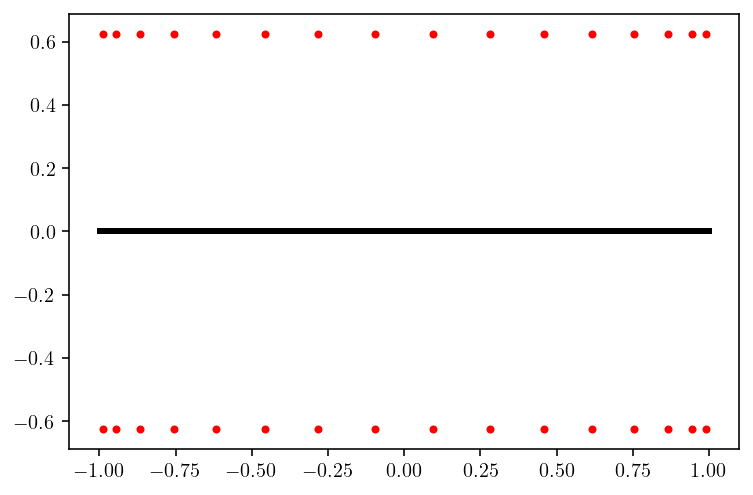

/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log10
/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log10


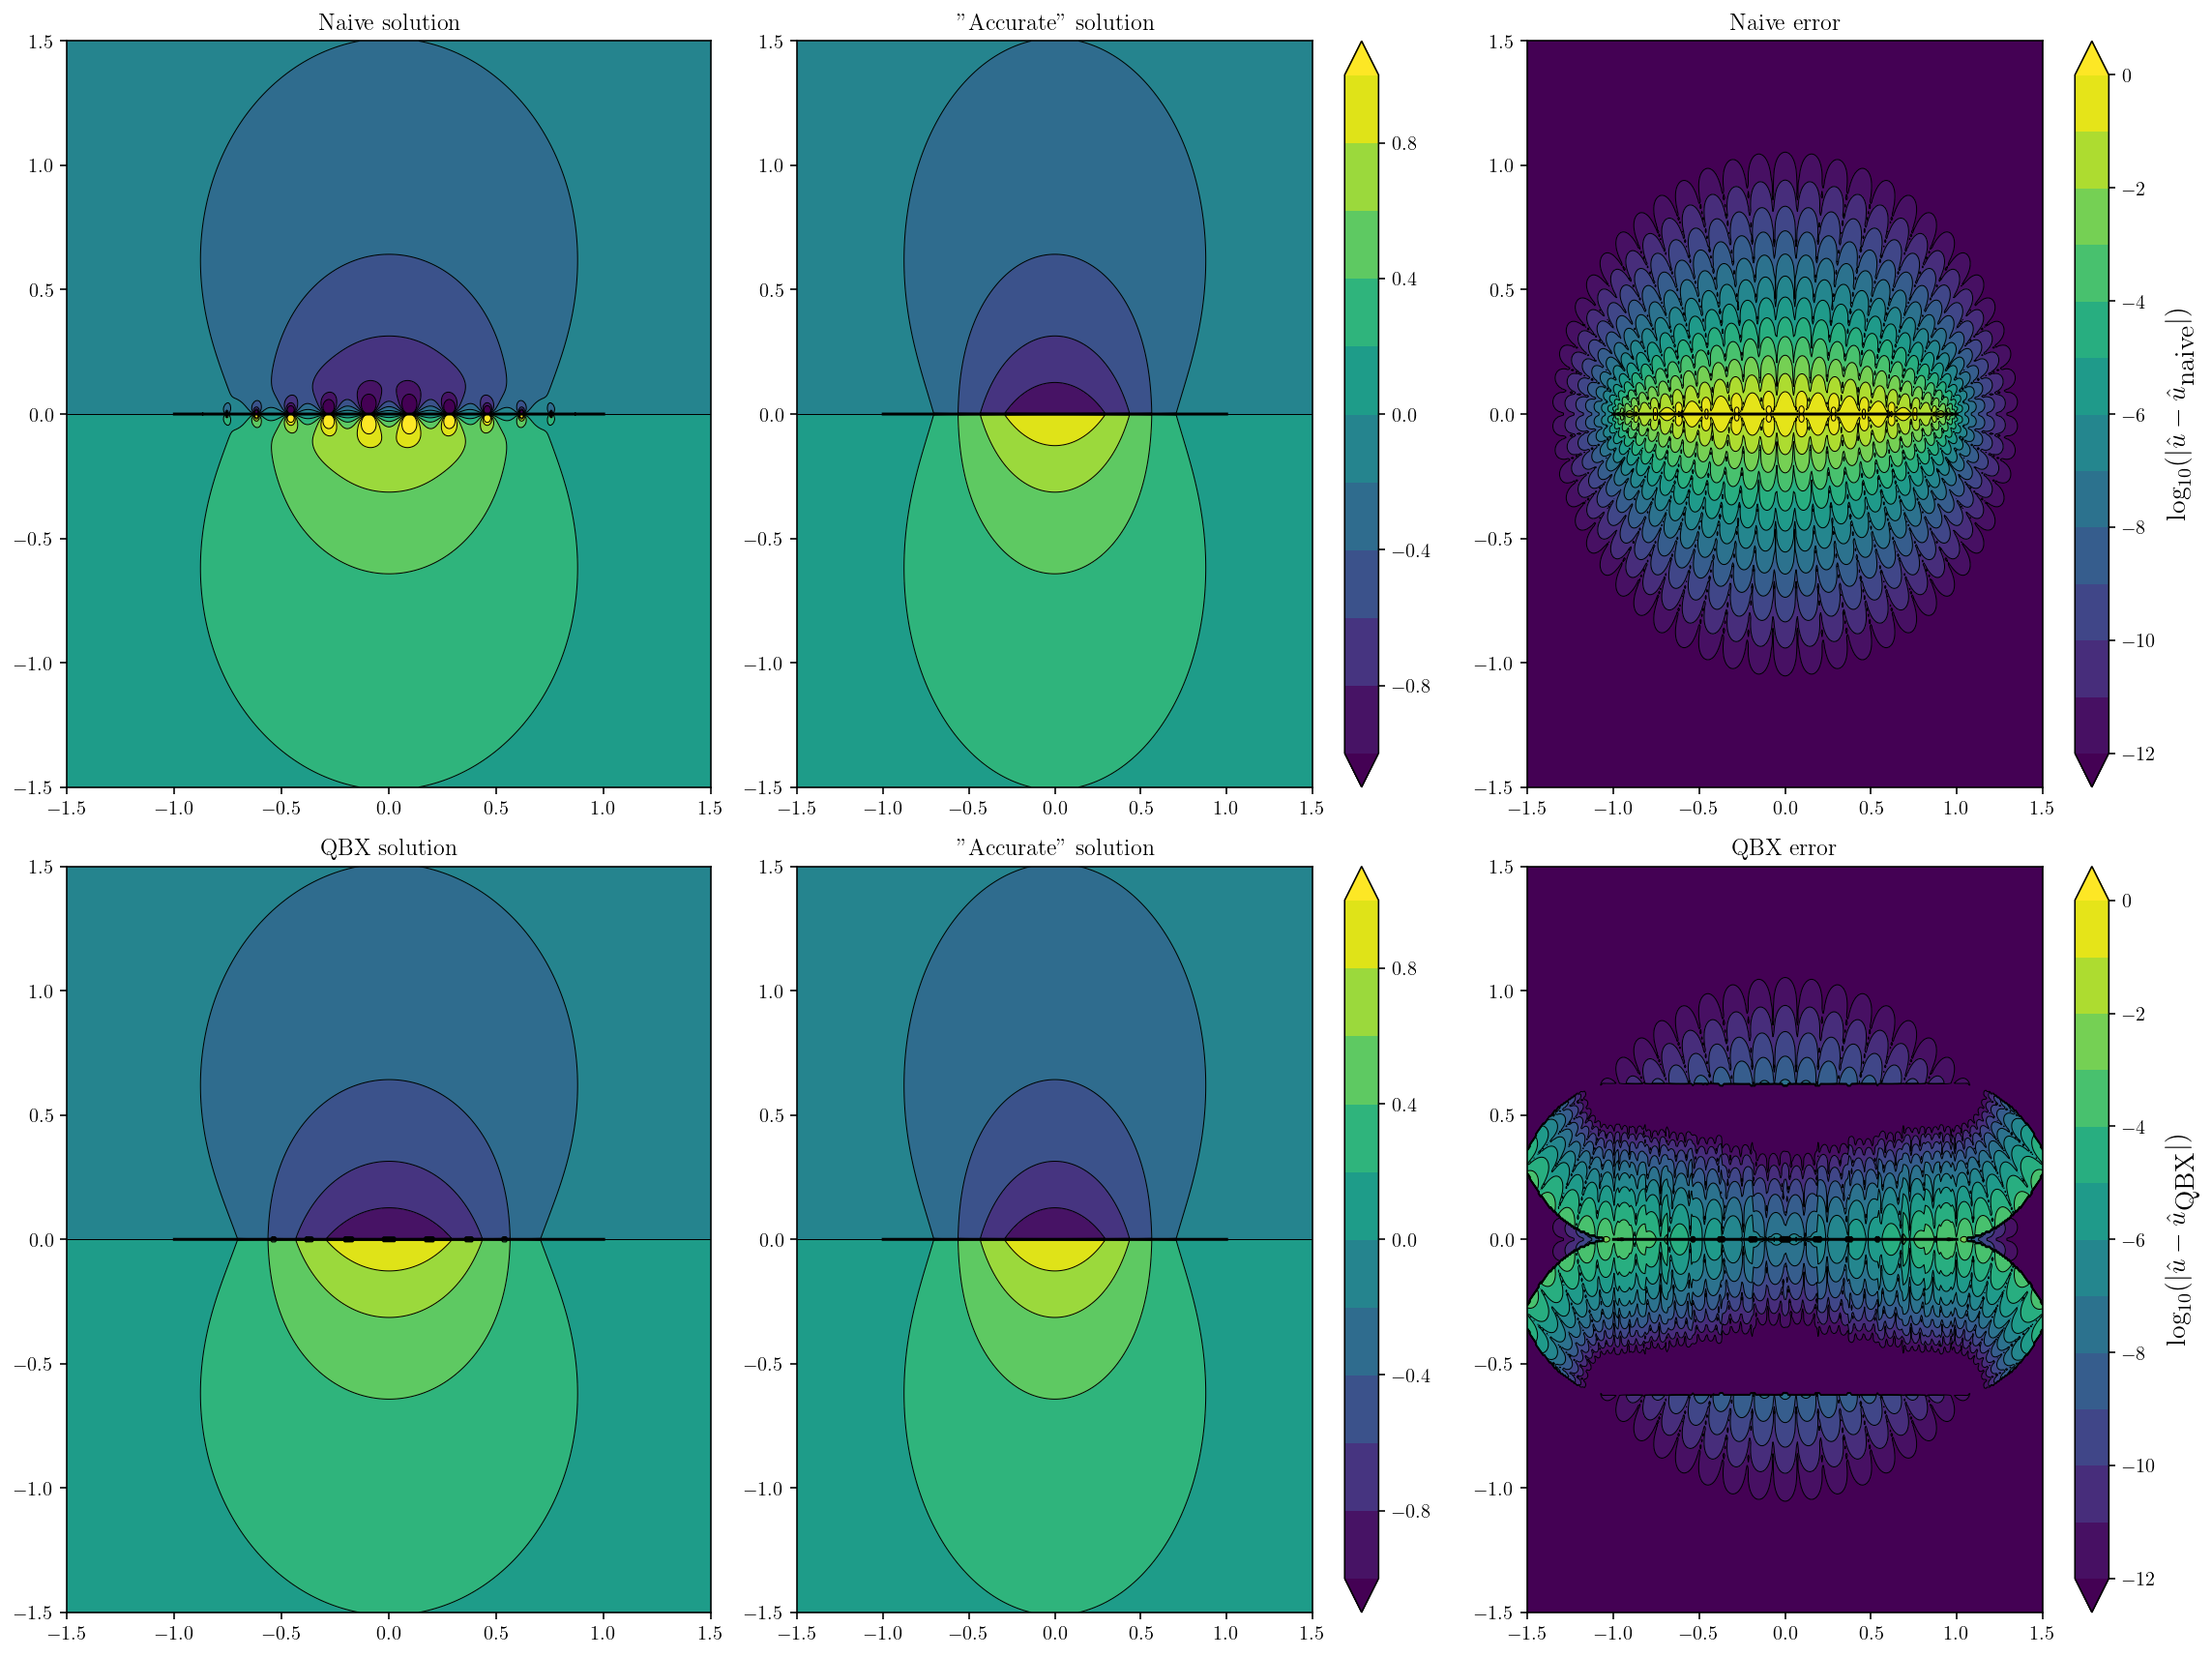

In [8]:
def line(q):
    return q, 0 * q, 0 * q, np.ones_like(q), 1.0
qbx_example(double_layer_matrix, surface_fnc=line, n=16, offset_mult=5, kappa=3, qbx_p=15)

# 2.2 - $\sigma_{yz}$ from a line source

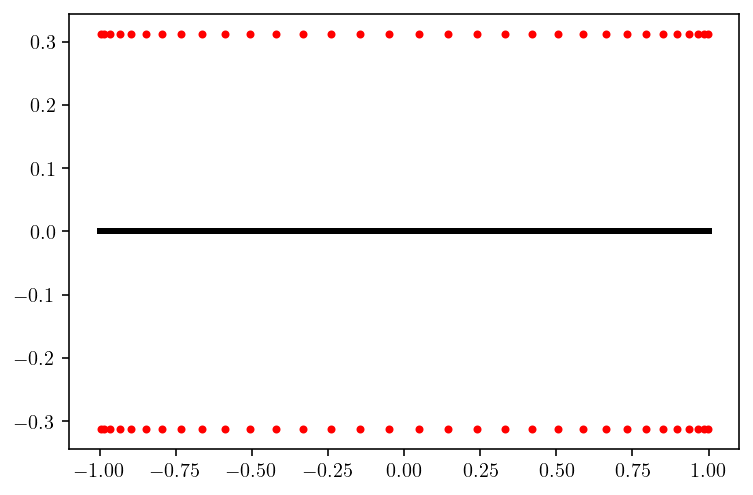

/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log10
/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log10


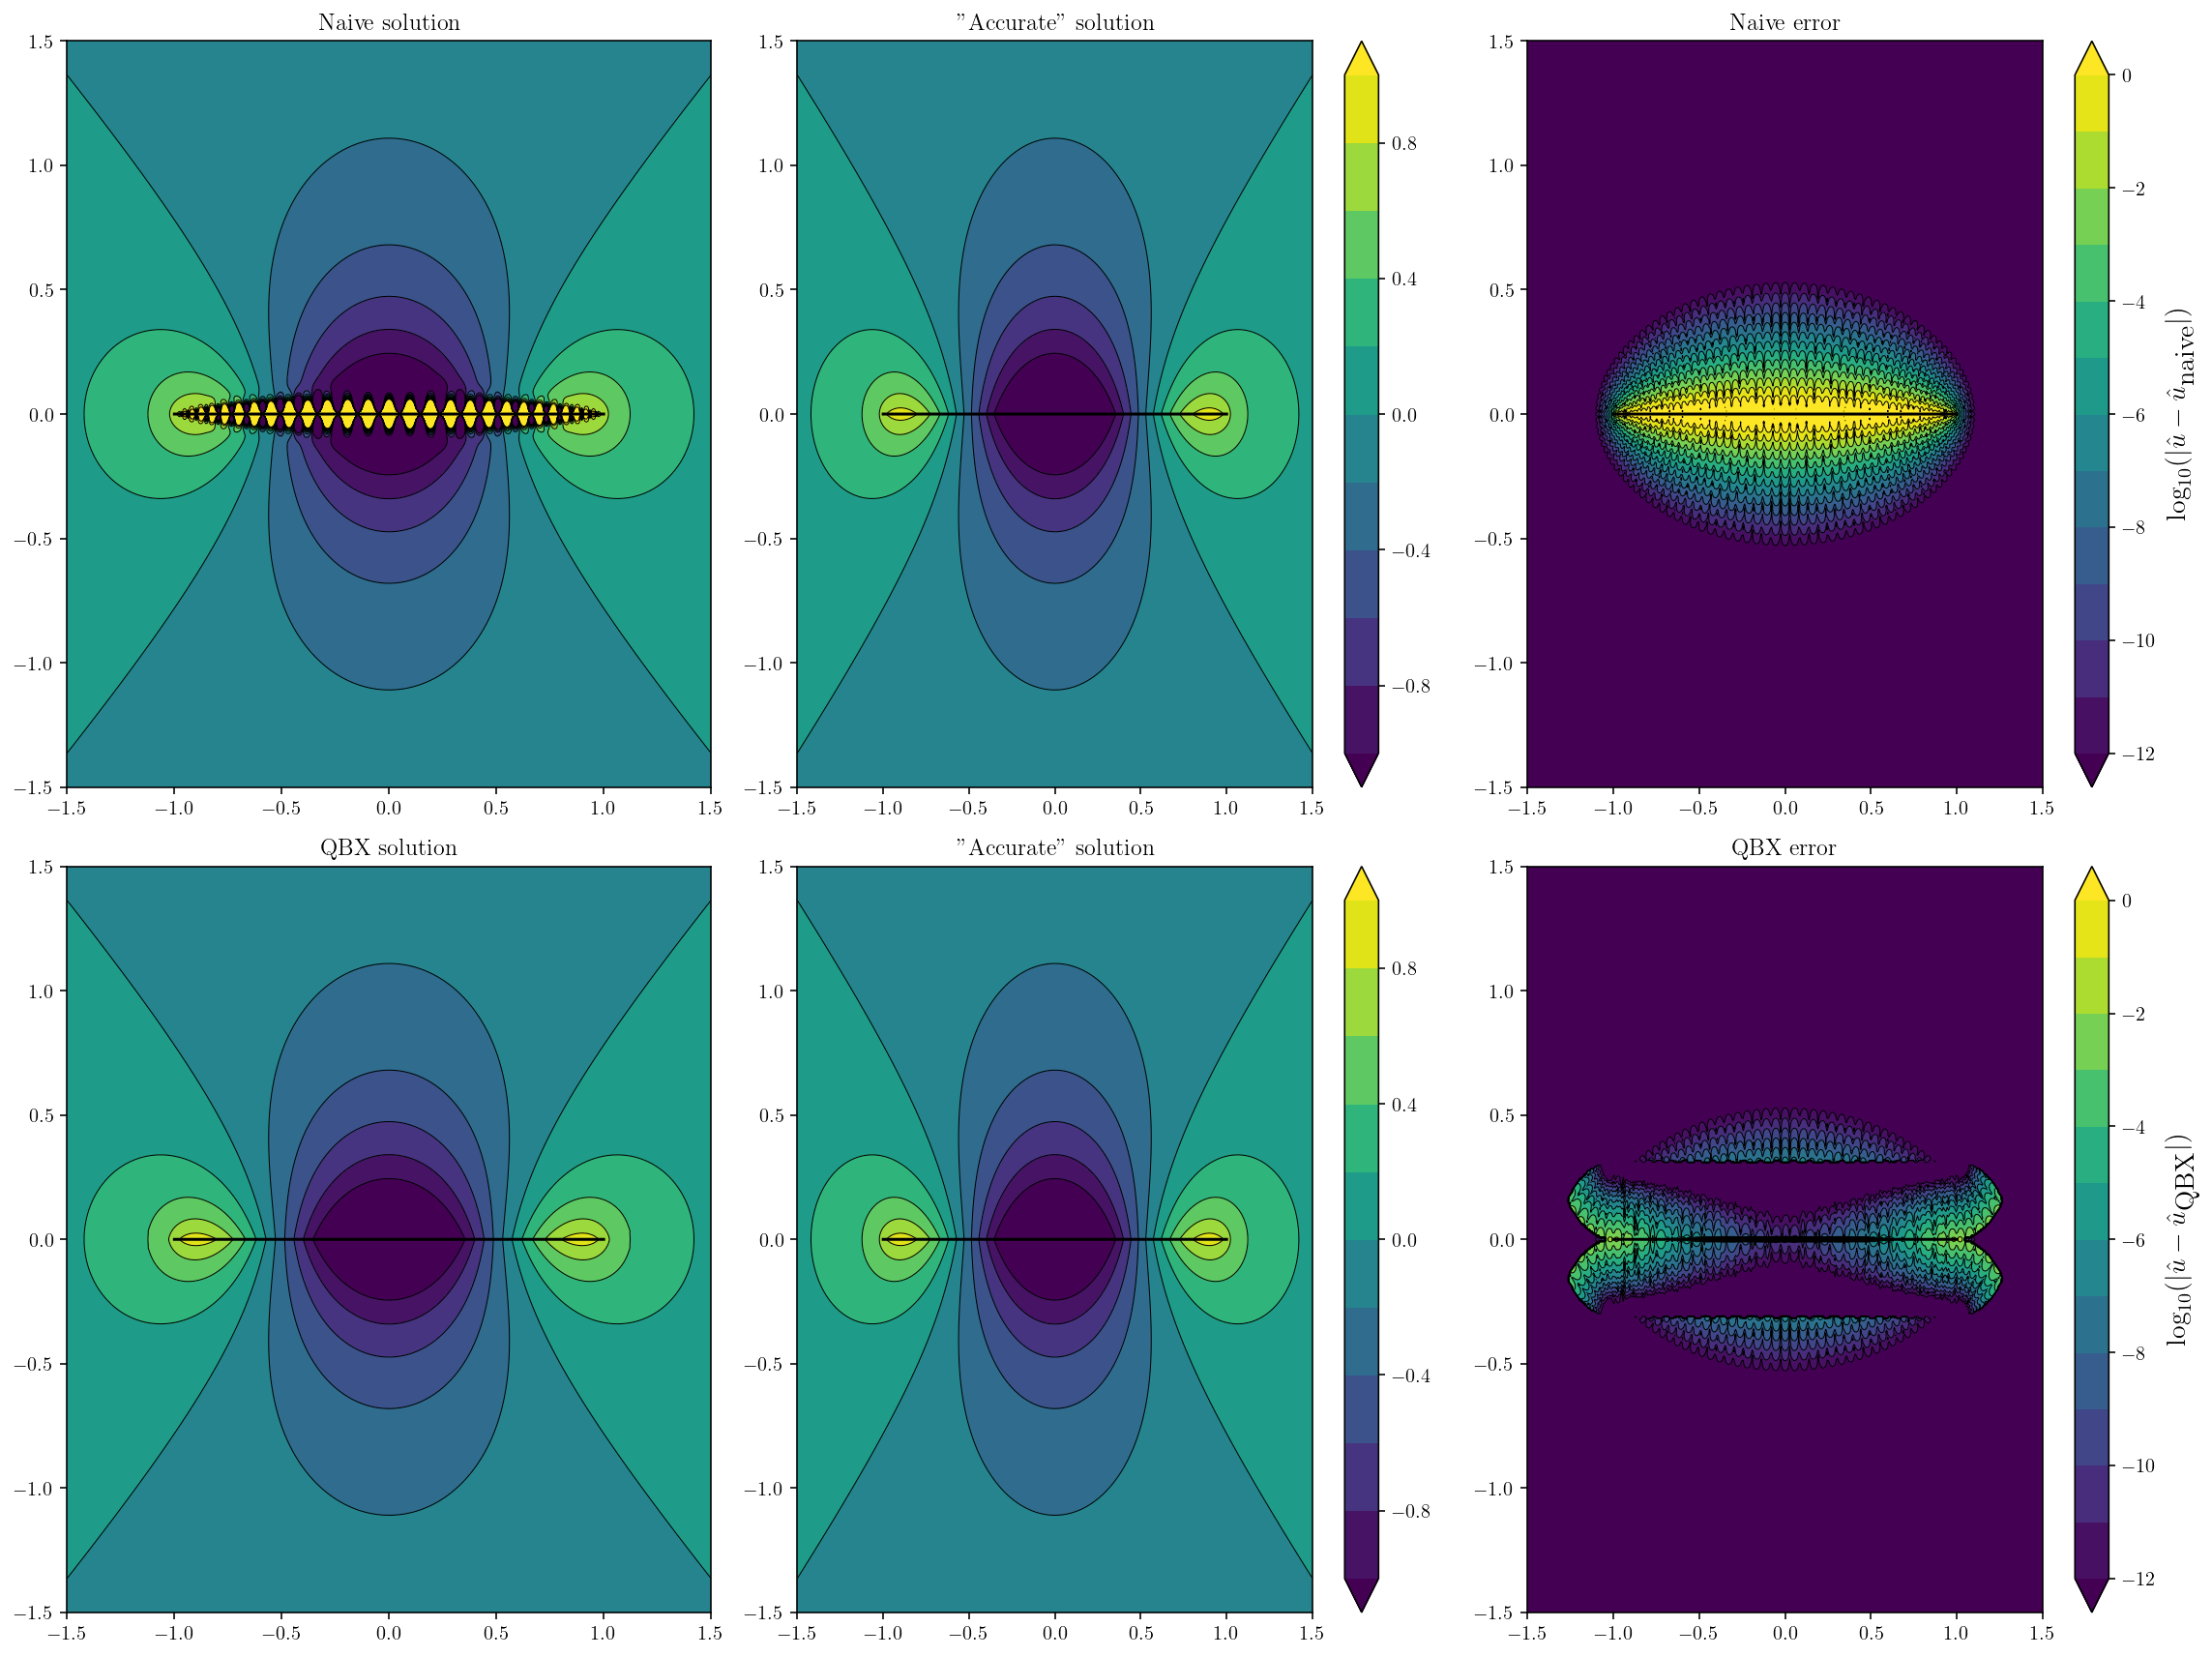

In [9]:
qbx_example(hypersingular_matrix, surface_fnc=line, n=32, offset_mult=5, kappa=5, qbx_p=15)

# 2.3 - $u$ from an arc source

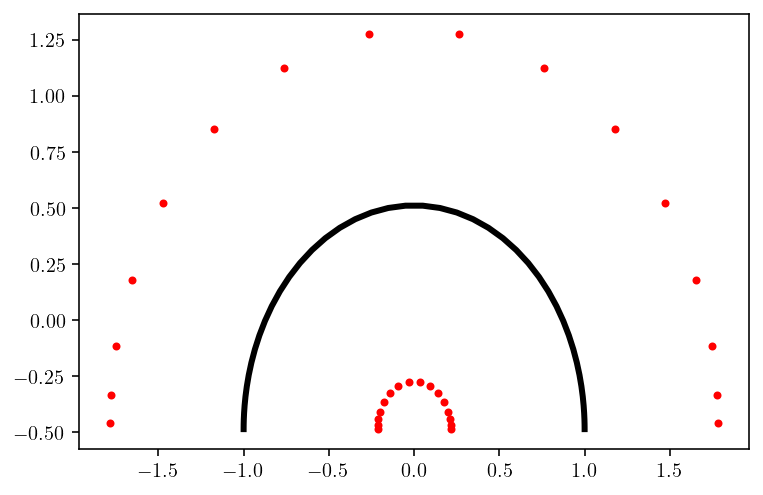

/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log10
/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log10


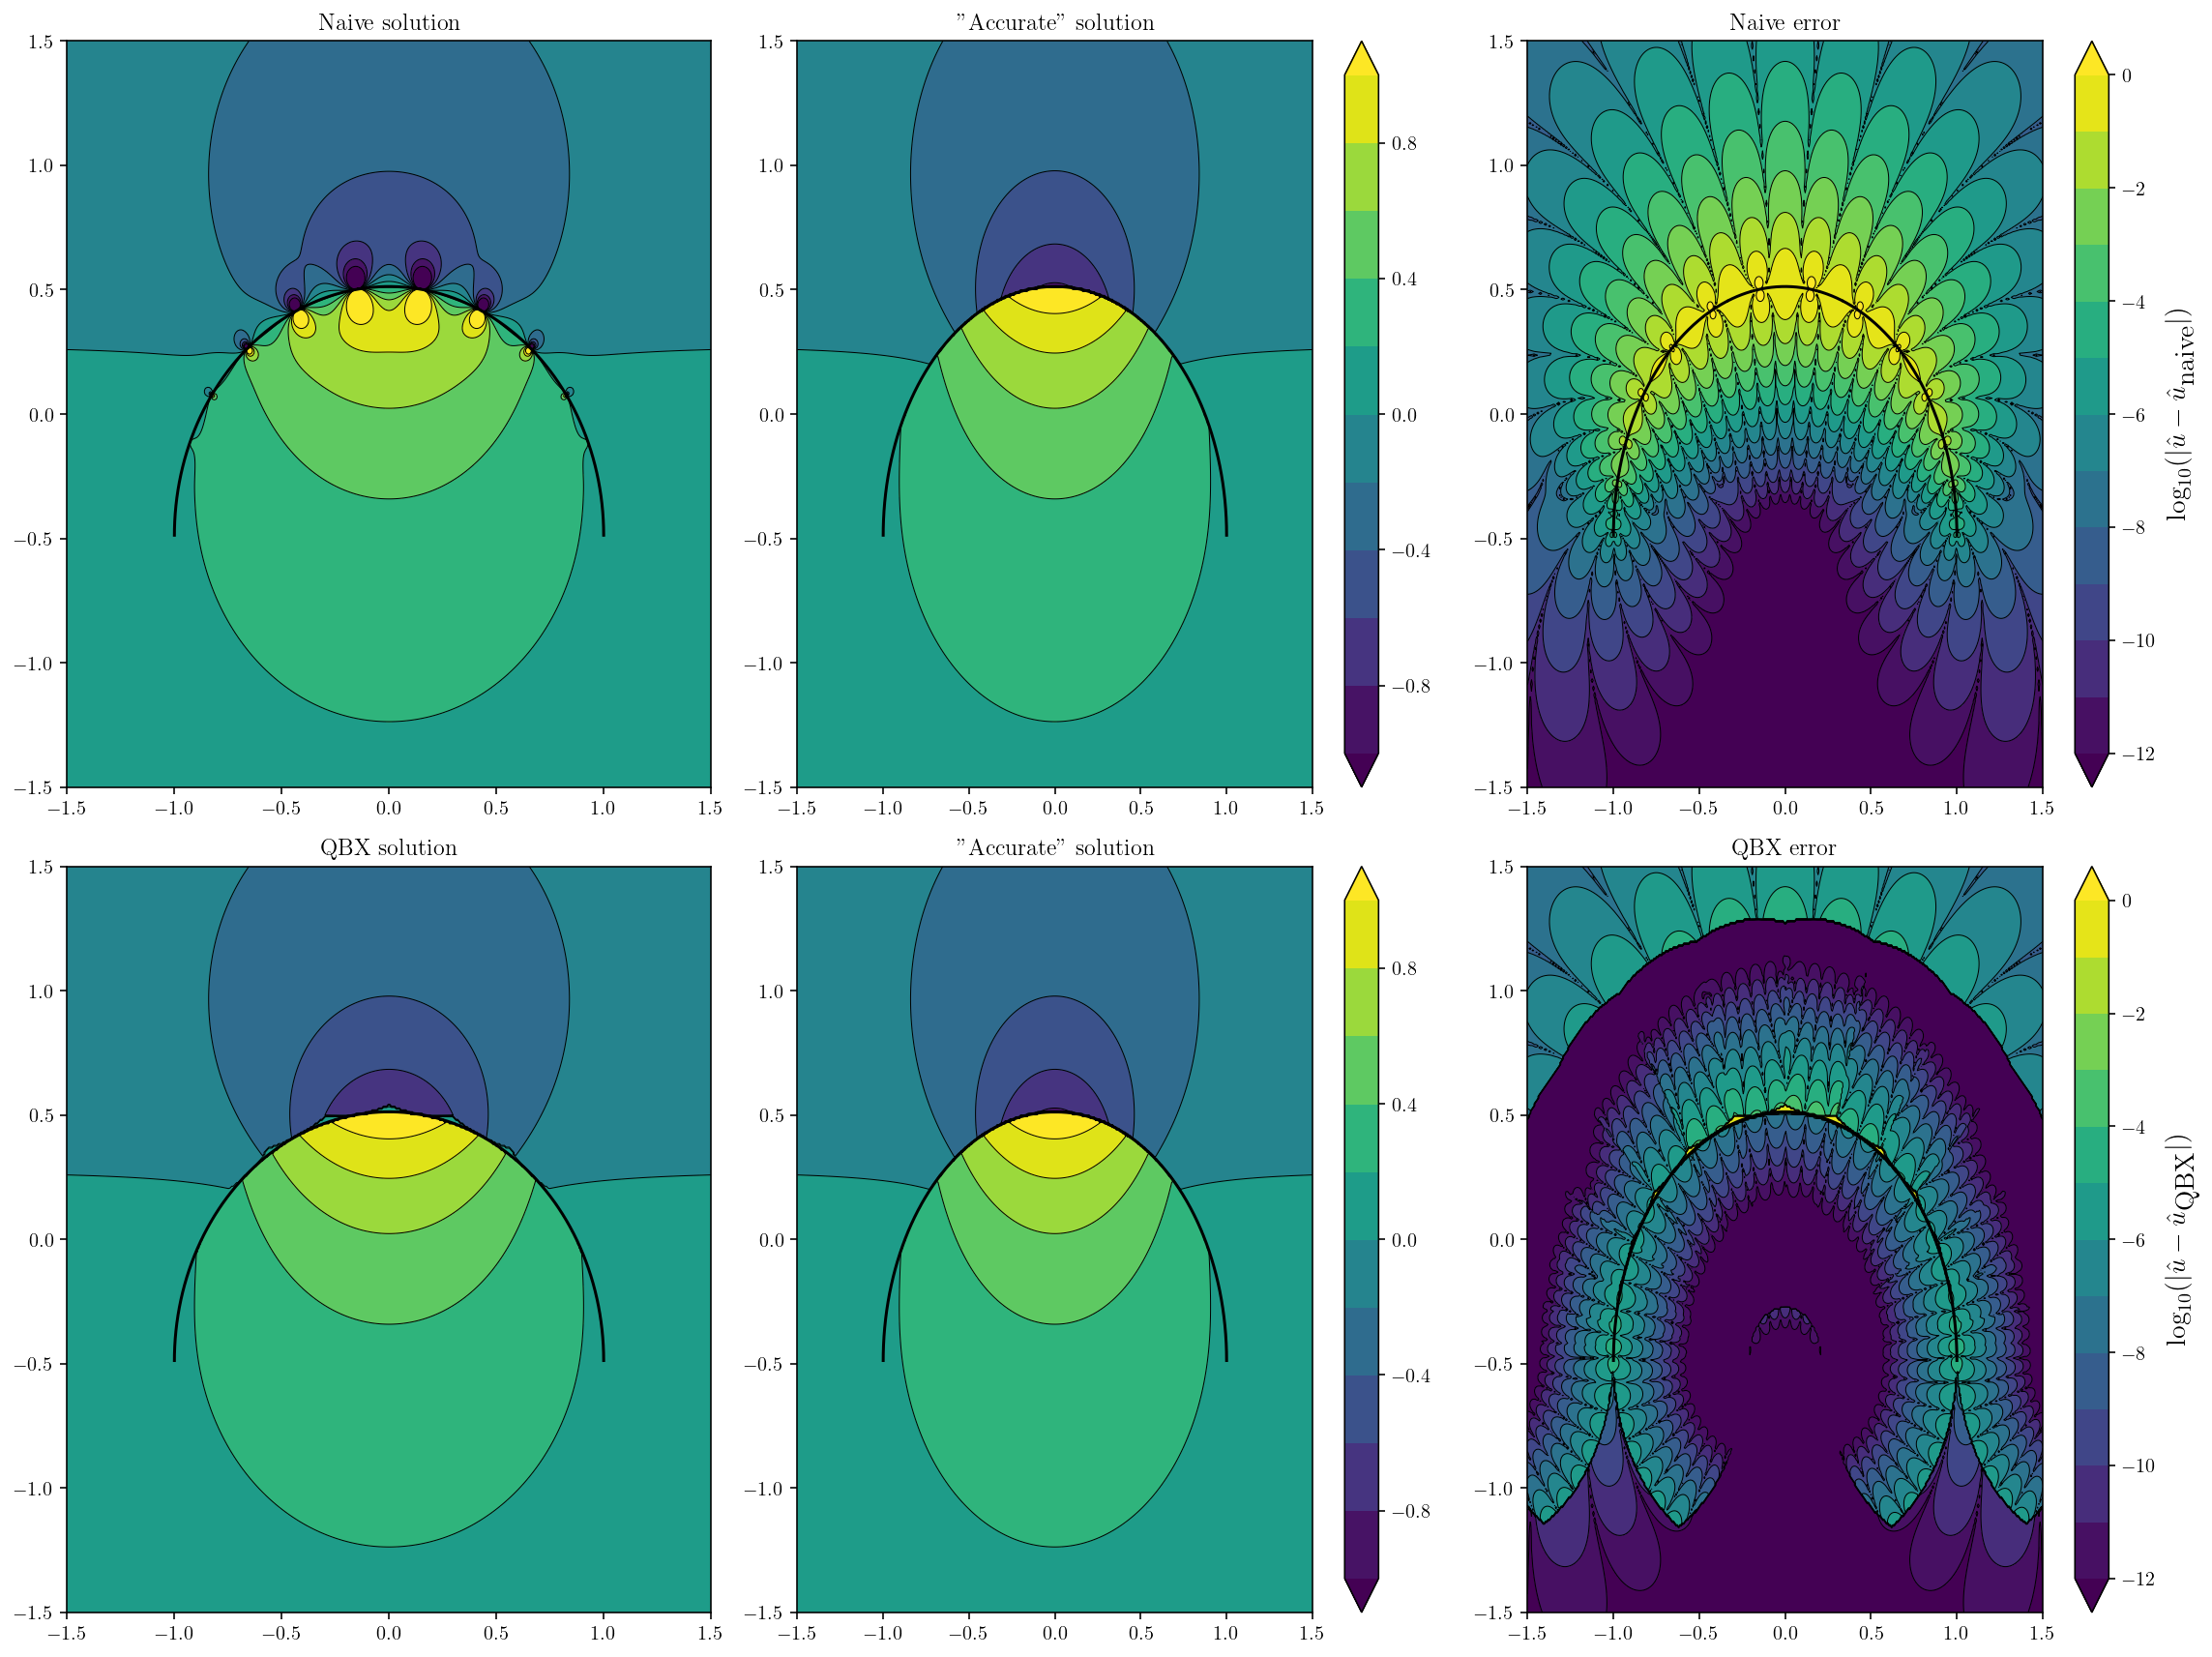

In [10]:
def arc(q):
    t = 0.5 * np.pi * q + 0.5 * np.pi
    x = np.cos(t)
    y = np.sin(t)
    nx = x.copy()
    ny = y.copy()
    y -= np.mean(y)
    return x, y, nx, ny, 0.5 * np.pi
qbx_example(double_layer_matrix, surface_fnc=arc, n=16, offset_mult=4, kappa=3, qbx_p=20)

# 2.4 - $\sigma_{yz}$ from an arc source

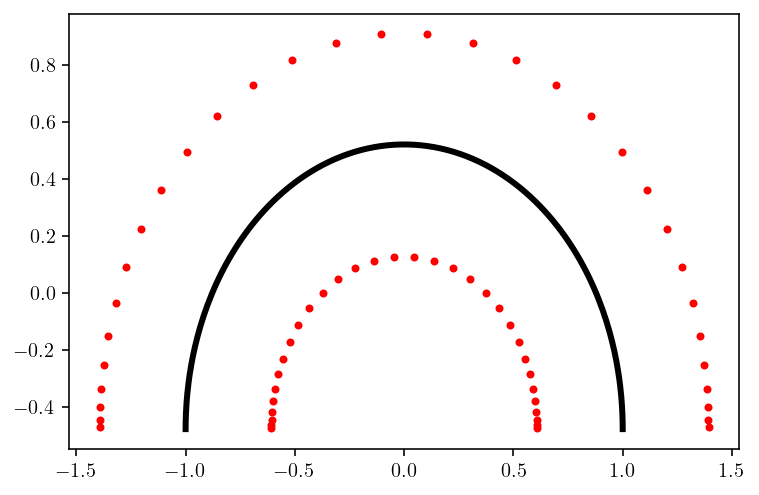

/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log10
/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log10


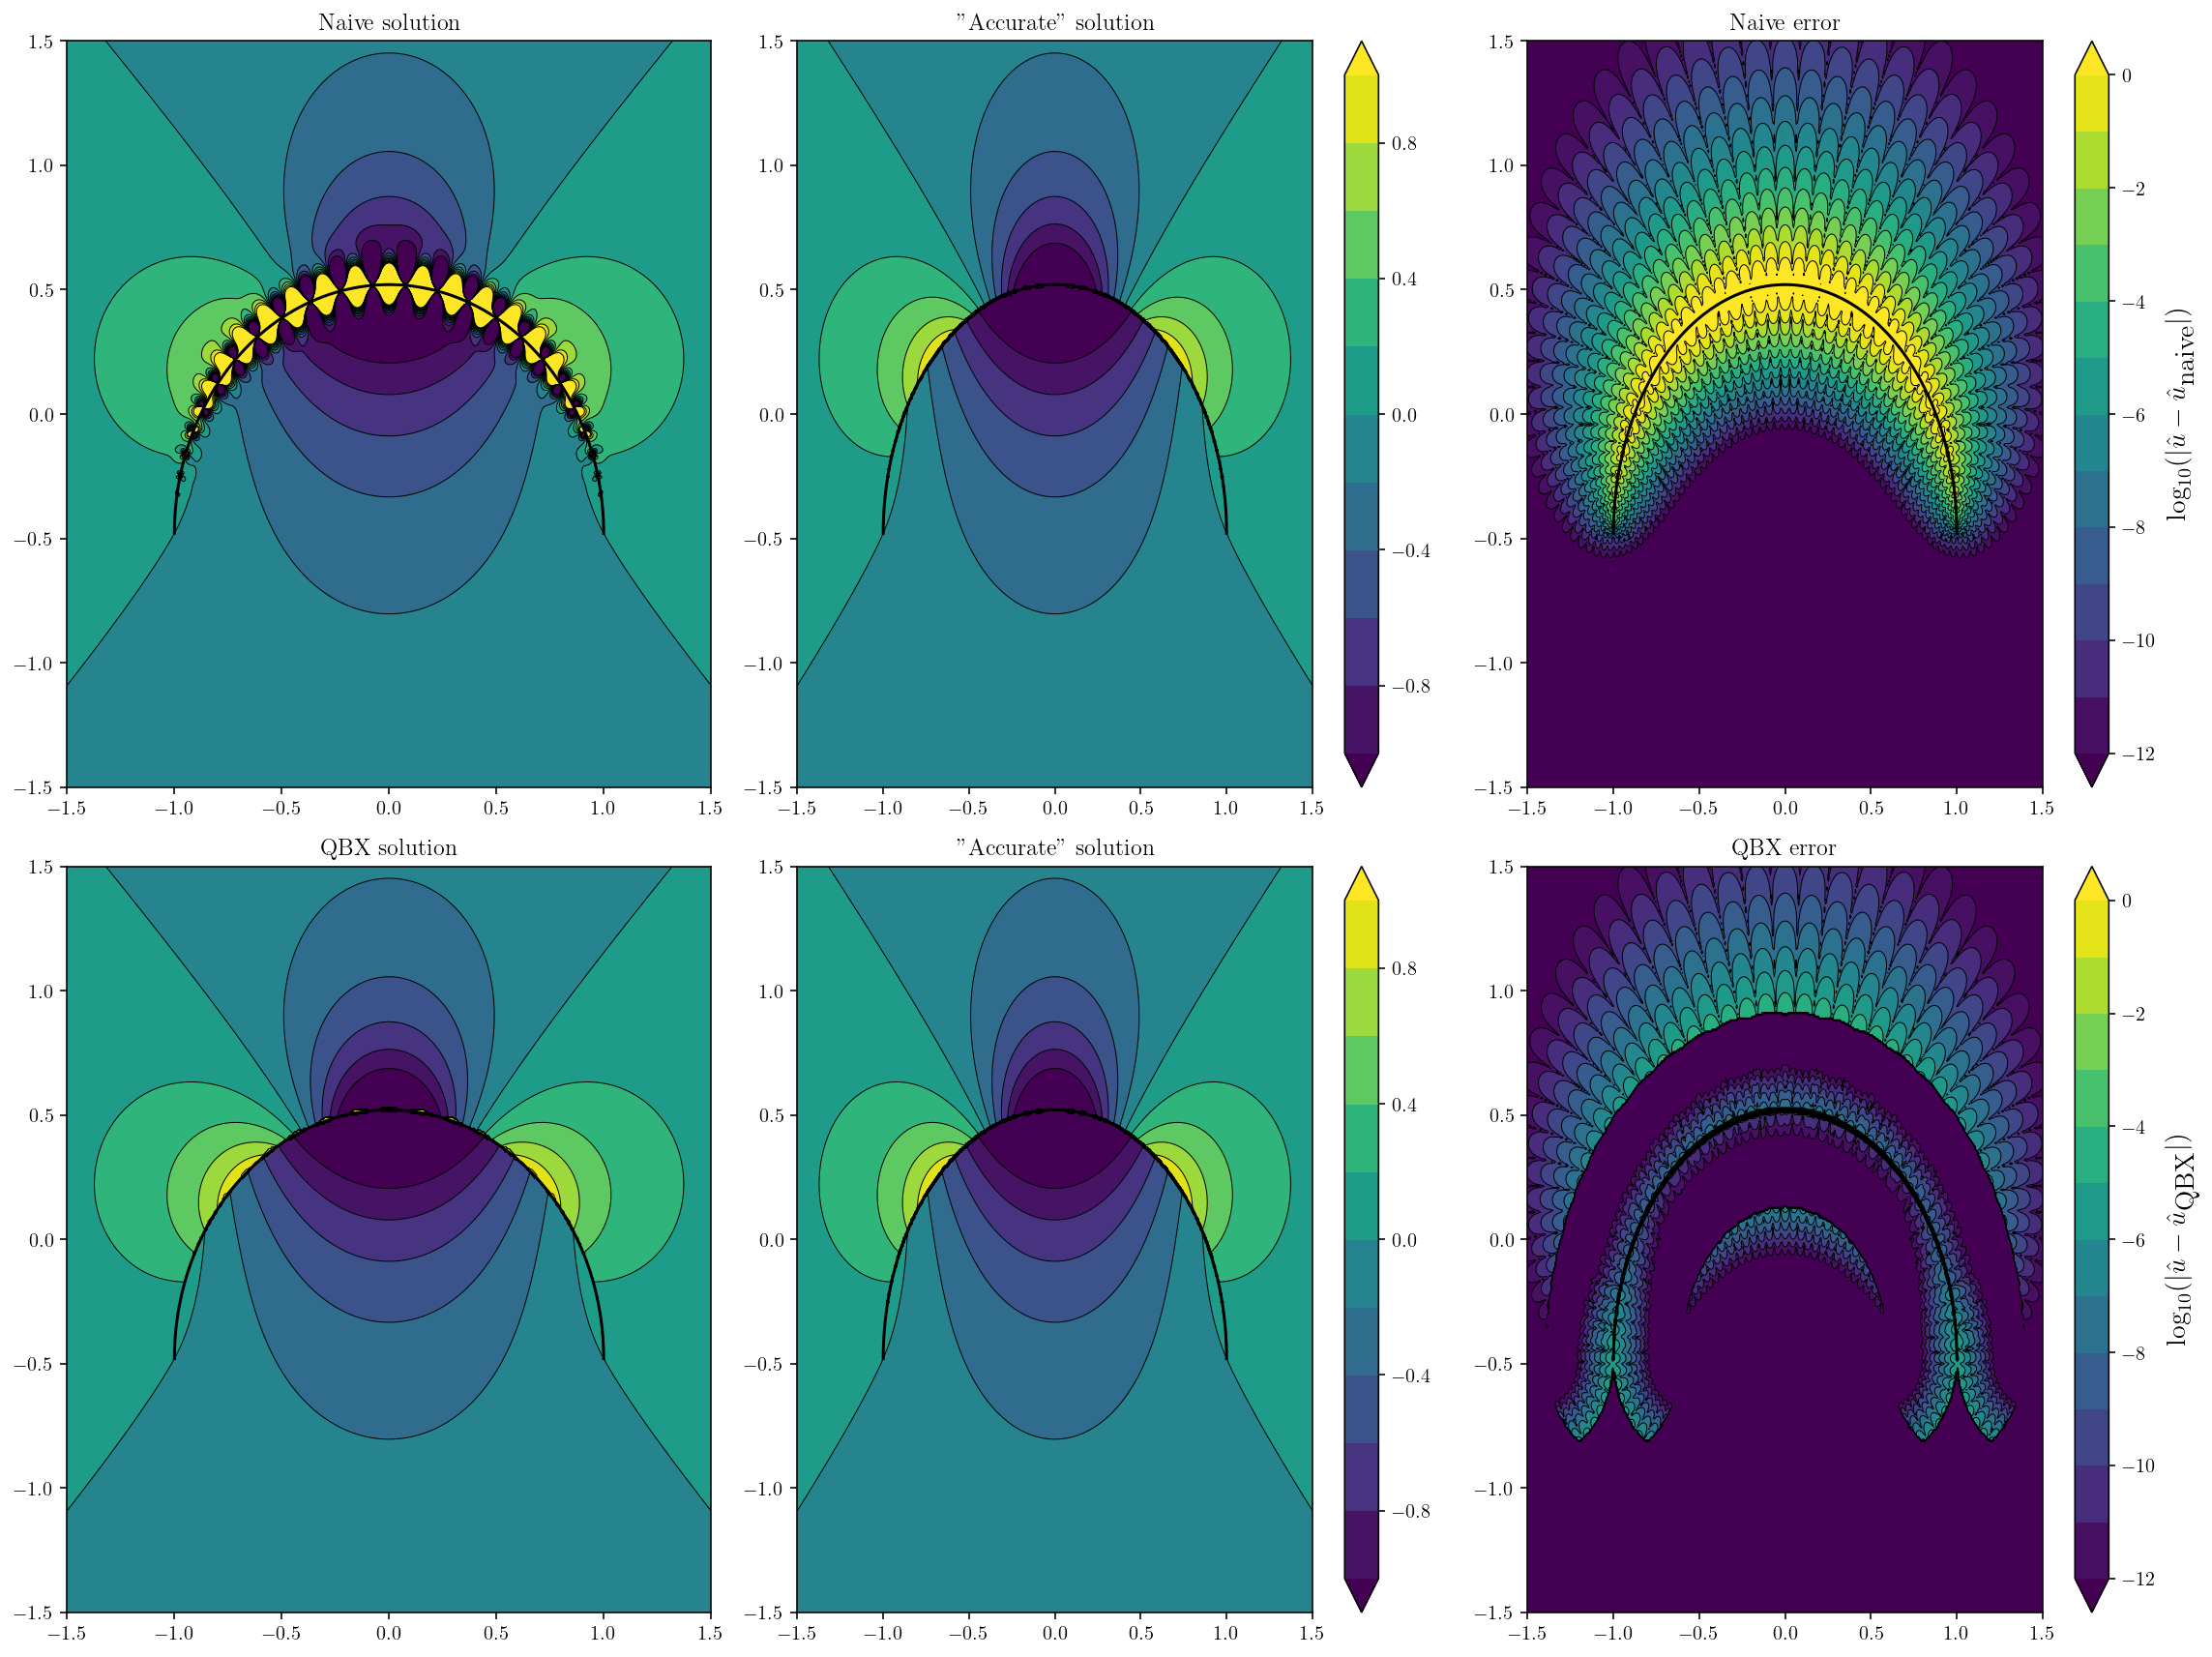

In [11]:
qbx_example(hypersingular_matrix, surface_fnc=arc, n=32, offset_mult=4, kappa=5, qbx_p=20)

# 2.5 - $u$ from a challenging wavy source

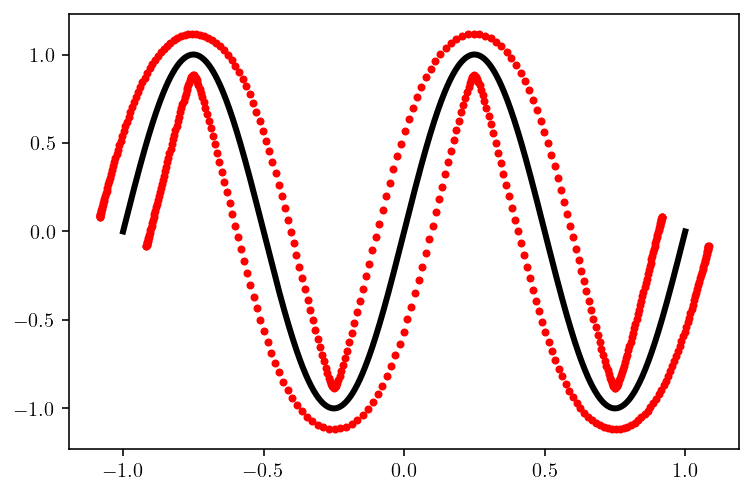

/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log10
/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log10


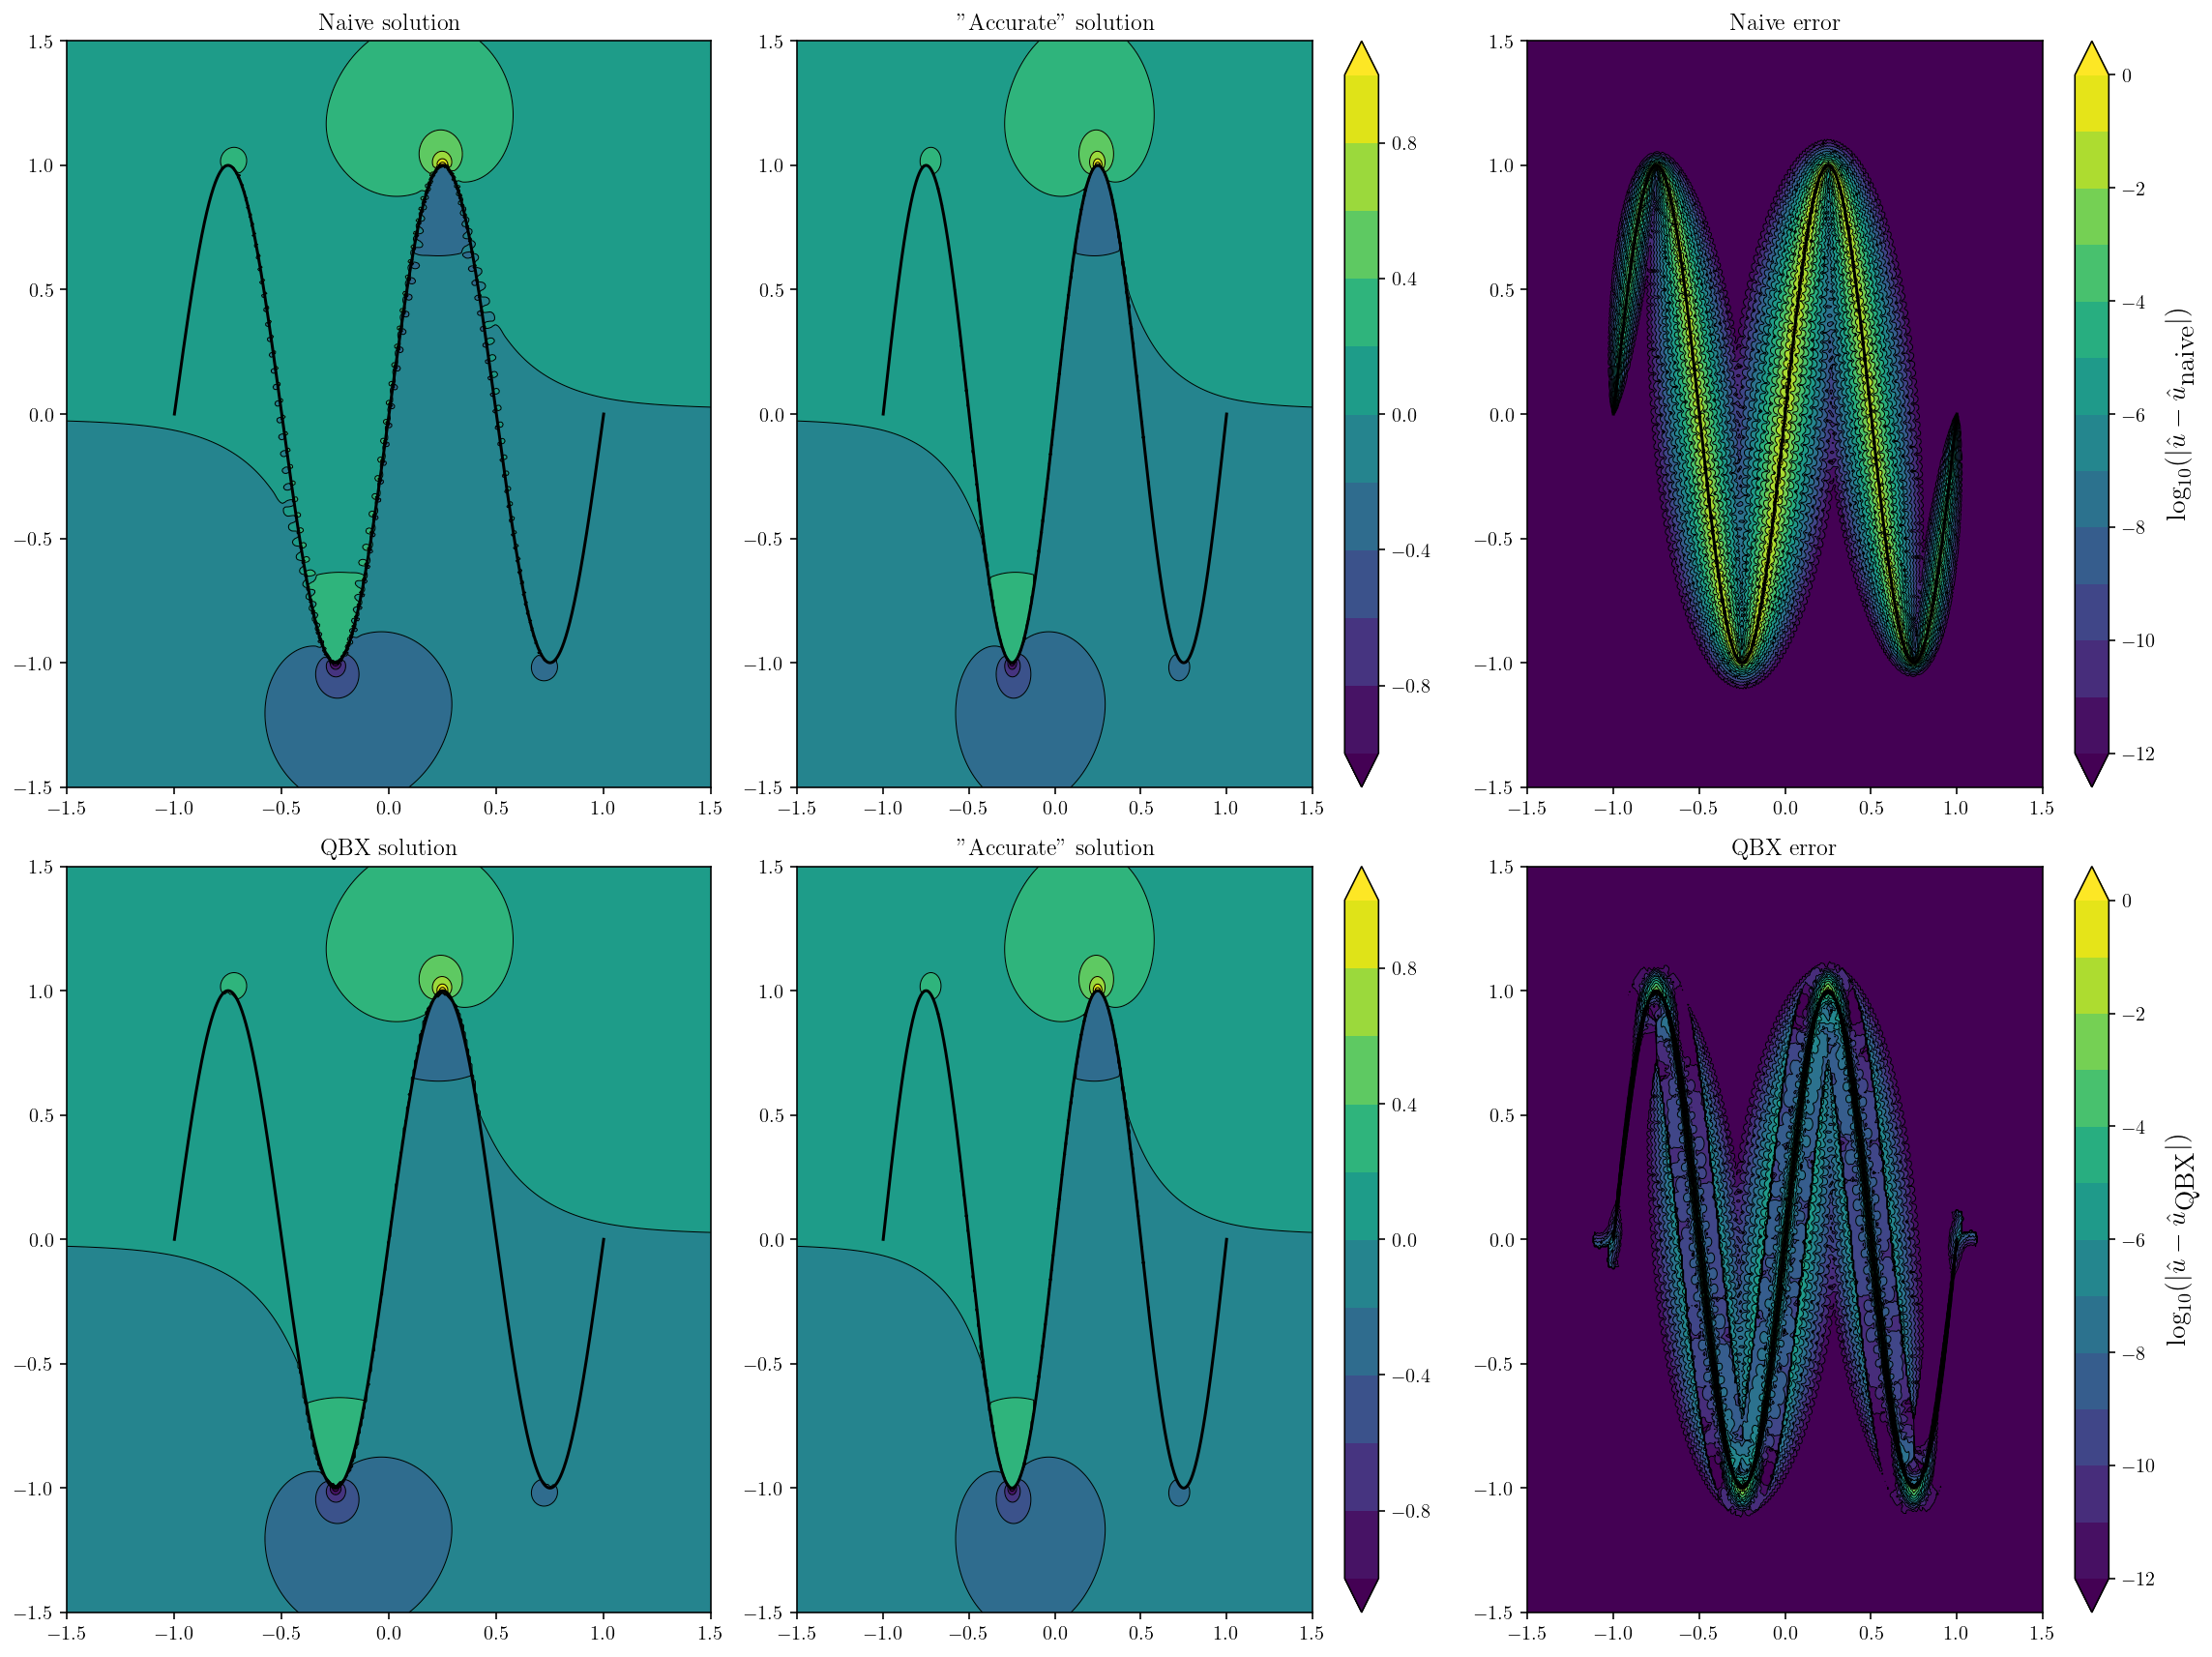

In [12]:
def wavy(q):
    t = (q + 1) * 2 * np.pi
    x, y = q, np.sin(t)
    
    dxdt = 1.0
    dydt = np.cos(t)
    ddt_norm = np.sqrt(dxdt ** 2 + dydt ** 2)
    dxdt /= ddt_norm
    dydt /= ddt_norm
    
    return x, y, dydt, -dxdt, 1.0

qbx_example(double_layer_matrix, surface_fnc=wavy, n=256, offset_mult=15, kappa=5, qbx_p=15)

# 2.6 - $\sigma_{yz}$ from a challenging wavy source

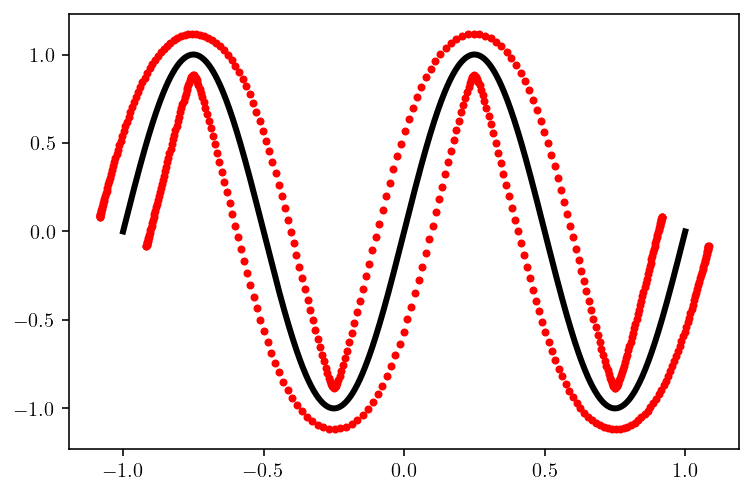

/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log10
/home/tbent/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log10


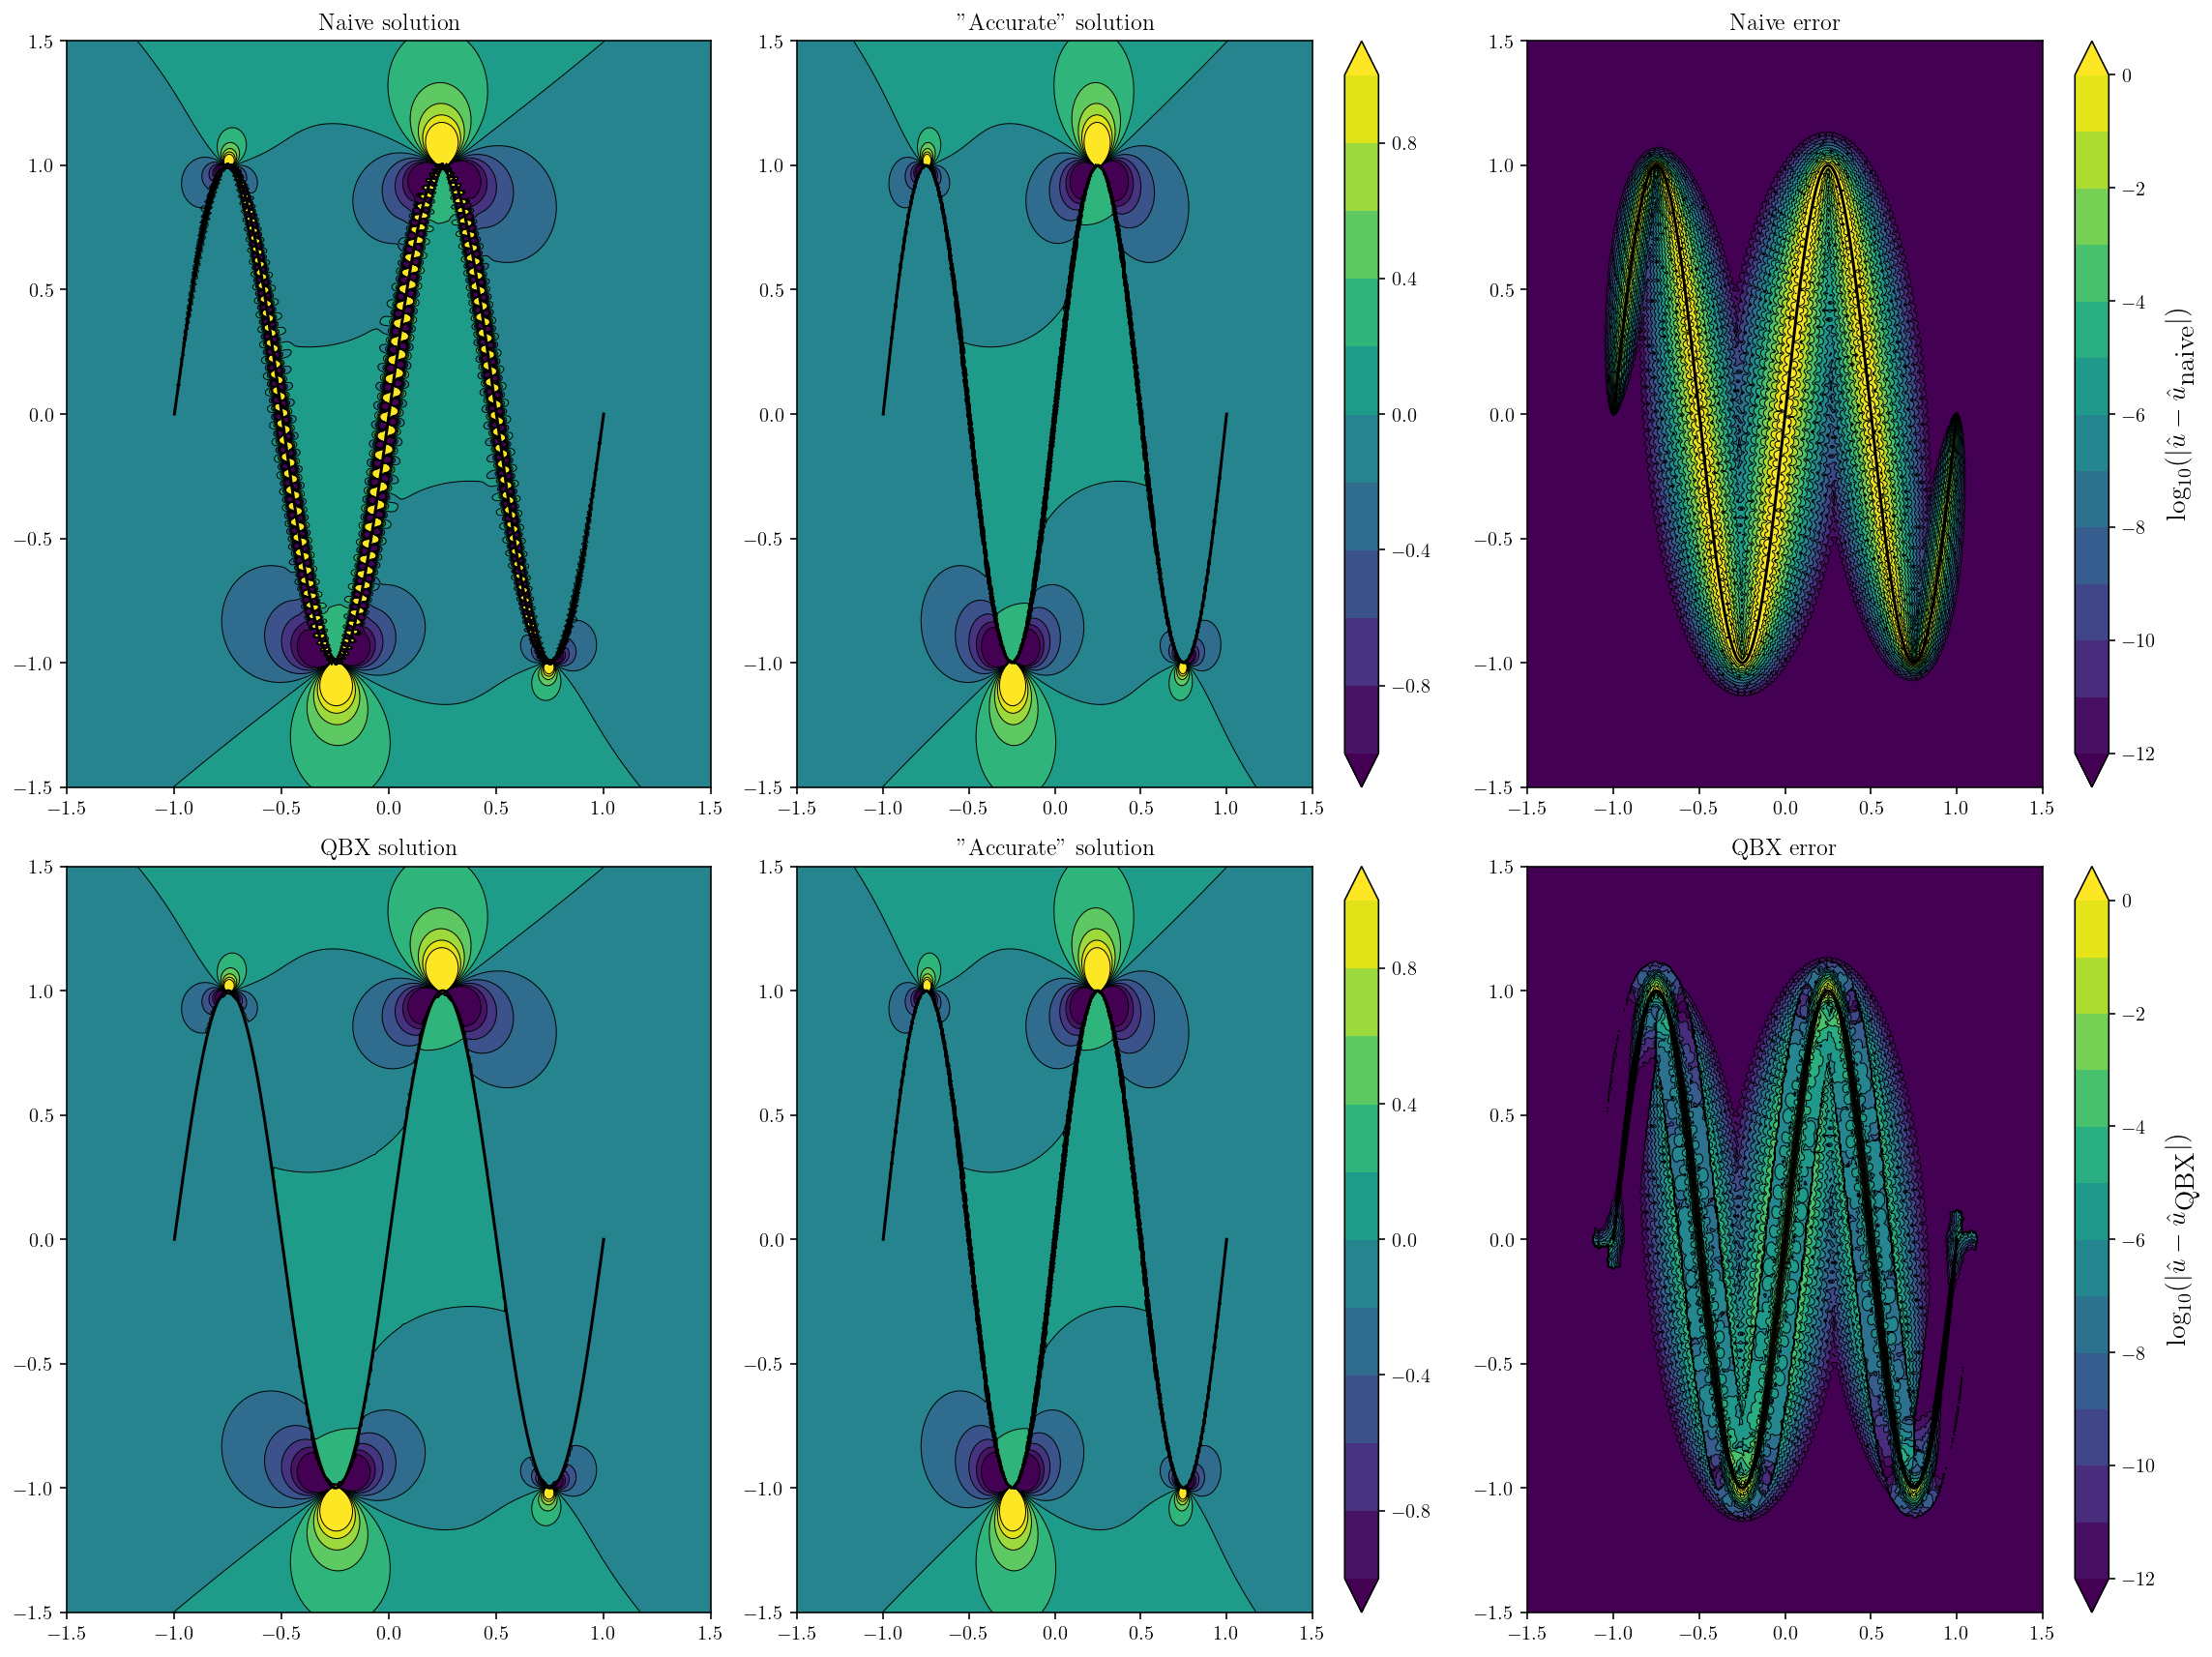

In [13]:
qbx_example(hypersingular_matrix, surface_fnc=wavy, n=256, offset_mult=15, kappa=5, qbx_p=15)